Comparing the relationship between training samples and the choice of training your model from the new model using a pretrained convolution network.

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"varshiniburgulaa","key":"e8798a3cd183d577098b86945b93d1c1"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats

!unzip -qq dogs-vs-cats.zip
!unzip -qq test1.zip
!unzip -qq train.zip

100% 809M/812M [00:27<00:00, 31.1MB/s]
100% 812M/812M [00:27<00:00, 30.8MB/s]


Question 1

Transferring pictures to the test, validation, and training directories respectively.

In [3]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Initially taking 1000 samples for training set
make_subset("train", start_index=0, end_index=1000)
#500 samples for validation set
make_subset("validation", start_index=1000, end_index=1500)
#500 for test set
make_subset("test", start_index=1500, end_index=2000)

Data Processing

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [5]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [6]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [7]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [8]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(4, 4)
(4, 4)
(4, 4)


In [9]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Building the model

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [11]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

Using a dataset for Modelfitting

In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 17s 55ms/step - loss: 0.6979 - accuracy: 0.5065 - val_loss: 0.6918 - val_accuracy: 0.6150
Epoch 2/30
63/63 [==============================] - 3s 46ms/step - loss: 0.6928 - accuracy: 0.5360 - val_loss: 0.6899 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 3s 48ms/step - loss: 0.6825 - accuracy: 0.5690 - val_loss: 0.6562 - val_accuracy: 0.5950
Epoch 4/30
63/63 [==============================] - 3s 45ms/step - loss: 0.6541 - accuracy: 0.6140 - val_loss: 0.6193 - val_accuracy: 0.6810
Epoch 5/30
63/63 [==============================] - 3s 44ms/step - loss: 0.6391 - accuracy: 0.6540 - val_loss: 0.6288 - val_accuracy: 0.6350
Epoch 6/30
63/63 [==============================] - 3s 44ms/step - loss: 0.6012 - accuracy: 0.6665 - val_loss: 0.6249 - val_accuracy: 0.6660
Epoch 7/30
63/63 [==============================] - 3s 47ms/step - loss: 0.5797 - accuracy: 0.6980 - val_loss: 0.5782 - val_accuracy: 0.7110
Epoch 8/30
6

Plotting the training-related loss and accuracy plots

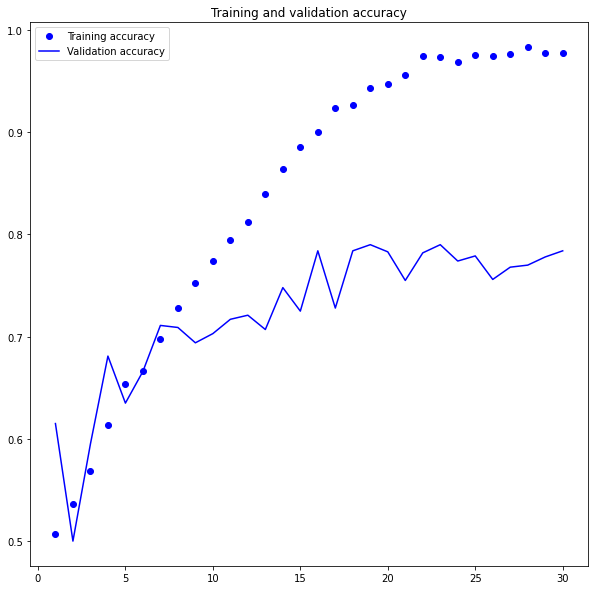

<Figure size 432x288 with 0 Axes>

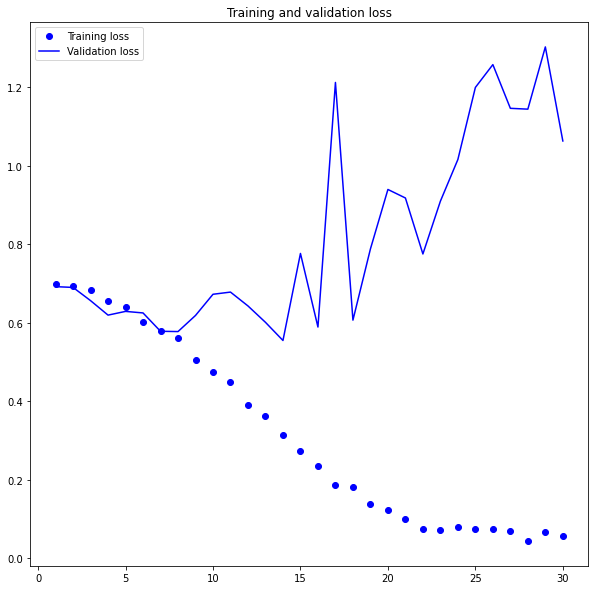

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10,10))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Model evaluation using the test set

In [15]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 17ms/step - loss: 0.6019 - accuracy: 0.7370
Test accuracy: 0.737


Question 2

Using data augmentation

In [16]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Here I have increased training sample size to 1500 and keeping the validation and test sample size to 500 each as before
make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [17]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

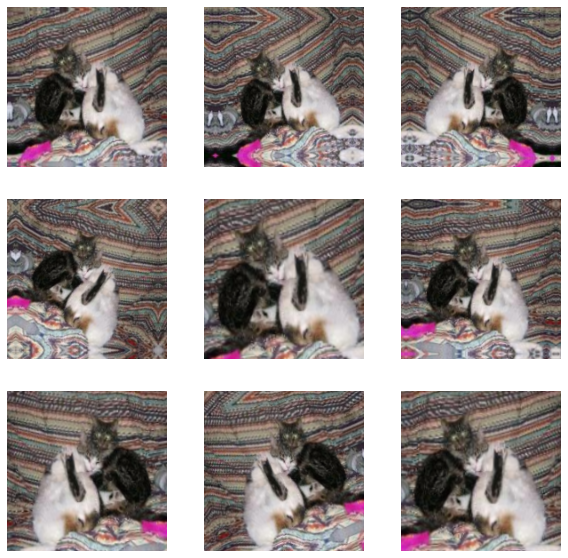

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [19]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the regularized convolutional network

In [20]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50


63/63 [==============================] - 13s 150ms/step - loss: 0.7029 - accuracy: 0.4835 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 9s 140ms/step - loss: 0.6994 - accuracy: 0.5210 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 9s 142ms/step - loss: 0.6937 - accuracy: 0.5310 - val_loss: 0.6913 - val_accuracy: 0.5180
Epoch 4/50
63/63 [==============================] - 9s 142ms/step - loss: 0.6794 - accuracy: 0.5830 - val_loss: 0.8206 - val_accuracy: 0.5030
Epoch 5/50
63/63 [==============================] - 9s 144ms/step - loss: 0.6608 - accuracy: 0.6180 - val_loss: 0.6394 - val_accuracy: 0.6350
Epoch 6/50
63/63 [==============================] - 9s 140ms/step - loss: 0.6559 - accuracy: 0.6150 - val_loss: 0.6571 - val_accuracy: 0.5920
Epoch 7/50
63/63 [==============================] - 9s 136ms/step - loss: 0.6367 - accuracy: 0.6345 - val_loss: 0.6428 - val_accuracy: 0.6010
Epoch 8/50
63/63

Model evaluation using the test set

In [21]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 17ms/step - loss: 0.5277 - accuracy: 0.7600
Test accuracy: 0.760


Question 3

Finding the ideal training sample size to get best prediction results.

In [22]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#As increasing the sample size is always good than decreasing, here we're increasing the training the sample size to 2000
make_subset("train", start_index=0, end_index=2000)
#validation and test sample size 500 each
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

In [23]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50


63/63 [==============================] - 15s 153ms/step - loss: 0.6939 - accuracy: 0.4965 - val_loss: 0.6923 - val_accuracy: 0.5520
Epoch 2/50
63/63 [==============================] - 10s 148ms/step - loss: 0.6854 - accuracy: 0.5555 - val_loss: 0.6920 - val_accuracy: 0.5050
Epoch 3/50
63/63 [==============================] - 9s 143ms/step - loss: 0.6772 - accuracy: 0.5865 - val_loss: 0.6890 - val_accuracy: 0.5520
Epoch 4/50
63/63 [==============================] - 10s 154ms/step - loss: 0.6635 - accuracy: 0.5995 - val_loss: 0.6658 - val_accuracy: 0.5910
Epoch 5/50
63/63 [==============================] - 10s 150ms/step - loss: 0.6514 - accuracy: 0.6185 - val_loss: 0.6419 - val_accuracy: 0.6220
Epoch 6/50
63/63 [==============================] - 9s 144ms/step - loss: 0.6390 - accuracy: 0.6370 - val_loss: 0.6476 - val_accuracy: 0.6230
Epoch 7/50
63/63 [==============================] - 10s 148ms/step - loss: 0.6324 - accuracy: 0.6360 - val_loss: 0.6578 - val_accuracy: 0.5940
Epoch 8/50
6

In [25]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 17ms/step - loss: 0.5507 - accuracy: 0.7990
Test accuracy: 0.799


Question 4

Instantiating the VGG16 convolutional base

In [26]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [27]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Extracting the VGG16 features and corresponding labels



In [28]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 21ms/step


In [29]:
train_features.shape

(2000, 5, 5, 512)

In [30]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 8ms/step - loss: 17.6067 - accuracy: 0.9255 - val_loss: 4.7697 - val_accuracy: 0.9630
Epoch 2/20
63/63 [==============================] - 0s 5ms/step - loss: 3.4291 - accuracy: 0.9780 - val_loss: 3.1019 - val_accuracy: 0.9730
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 2.5399 - accuracy: 0.9825 - val_loss: 10.3706 - val_accuracy: 0.9580
Epoch 4/20
63/63 [==============================] - 0s 4ms/step - loss: 1.1468 - accuracy: 0.9900 - val_loss: 3.8413 - val_accuracy: 0.9750
Epoch 5/20
63/63 [==============================] - 0s 4ms/step - loss: 1.8494 - accuracy: 0.9885 - val_loss: 4.6989 - val_accuracy: 0.9770
Epoch 6/20
63/63 [==============================] - 0s 4ms/step - loss: 0.9541 - accuracy: 0.9925 - val_loss: 7.6338 - val_accuracy: 0.9650
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 0.0293 - accuracy: 0.9995 - val_loss: 4.1704 - val_accuracy: 0.9800
Epoch 8/20
63/63 [

Plotting all the outcomes

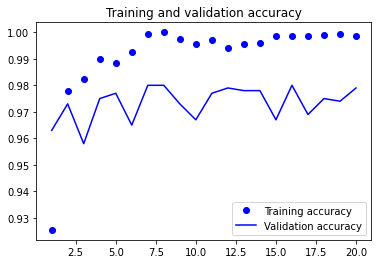

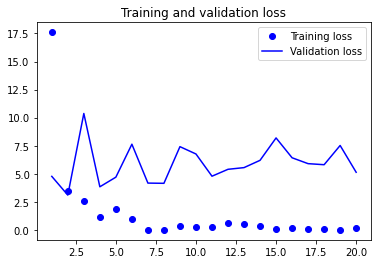

In [31]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [32]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [33]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [34]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


Adding a classifier and a data augmentation stage to the convolutional base

In [35]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [36]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50


63/63 [==============================] - 18s 235ms/step - loss: 17.8434 - accuracy: 0.9050 - val_loss: 3.7044 - val_accuracy: 0.9720
Epoch 2/50
63/63 [==============================] - 14s 226ms/step - loss: 6.1473 - accuracy: 0.9495 - val_loss: 3.7693 - val_accuracy: 0.9700
Epoch 3/50
63/63 [==============================] - 14s 225ms/step - loss: 4.8727 - accuracy: 0.9640 - val_loss: 5.1069 - val_accuracy: 0.9720
Epoch 4/50
63/63 [==============================] - 14s 224ms/step - loss: 3.8911 - accuracy: 0.9675 - val_loss: 5.7785 - val_accuracy: 0.9630
Epoch 5/50
63/63 [==============================] - 14s 224ms/step - loss: 3.8674 - accuracy: 0.9640 - val_loss: 4.9149 - val_accuracy: 0.9700
Epoch 6/50
63/63 [==============================] - 14s 224ms/step - loss: 3.1466 - accuracy: 0.9745 - val_loss: 4.7255 - val_accuracy: 0.9710
Epoch 7/50
63/63 [==============================] - 14s 228ms/step - loss: 3.4476 - accuracy: 0.9715 - val_loss: 3.8616 - val_accuracy: 0.9760
Epoch 8/5

In [37]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 88ms/step - loss: 4.1600 - accuracy: 0.9790
Test accuracy: 0.979


Modifying the trained mode

In [38]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [39]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Fine-tuning the model

In [40]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30


63/63 [==============================] - 20s 247ms/step - loss: 3.0286 - accuracy: 0.9670 - val_loss: 4.3326 - val_accuracy: 0.9770
Epoch 2/30
63/63 [==============================] - 15s 244ms/step - loss: 1.9800 - accuracy: 0.9800 - val_loss: 2.9969 - val_accuracy: 0.9770
Epoch 3/30
63/63 [==============================] - 15s 239ms/step - loss: 1.2866 - accuracy: 0.9805 - val_loss: 3.0300 - val_accuracy: 0.9770
Epoch 4/30
63/63 [==============================] - 15s 243ms/step - loss: 0.8160 - accuracy: 0.9870 - val_loss: 2.7877 - val_accuracy: 0.9810
Epoch 5/30
63/63 [==============================] - 15s 243ms/step - loss: 0.9565 - accuracy: 0.9860 - val_loss: 2.3688 - val_accuracy: 0.9820
Epoch 6/30
63/63 [==============================] - 15s 243ms/step - loss: 0.4940 - accuracy: 0.9895 - val_loss: 2.3112 - val_accuracy: 0.9810
Epoch 7/30
63/63 [==============================] - 15s 239ms/step - loss: 0.5574 - accuracy: 0.9895 - val_loss: 3.4164 - val_accuracy: 0.9760
Epoch 8/30

In [41]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 87ms/step - loss: 2.6963 - accuracy: 0.9710
Test accuracy: 0.971
